<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-12-03 17:00:00+09:00,463,0,533,2020-12-03 17:00:00+09:00
2020-12-04 17:00:00+09:00,406,0,449,2020-12-04 17:00:00+09:00
2020-12-05 17:00:00+09:00,541,0,584,2020-12-05 17:00:00+09:00
2020-12-06 17:00:00+09:00,413,0,327,2020-12-06 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-12-03 17:00:00+09:00,463,0,533,2020-12-03 17:00:00+09:00,493.571429,3455.0,0.0,0.0,466.428571,3265.0
2020-12-04 17:00:00+09:00,406,0,449,2020-12-04 17:00:00+09:00,477.714286,3344.0,0.0,0.0,449.142857,3144.0
2020-12-05 17:00:00+09:00,541,0,584,2020-12-05 17:00:00+09:00,470.714286,3295.0,0.0,0.0,452.428571,3167.0
2020-12-06 17:00:00+09:00,413,0,327,2020-12-06 17:00:00+09:00,458.857143,3212.0,0.0,0.0,439.428571,3076.0
2020-12-07 17:00:00+09:00,0,0,299,2020-12-07 17:00:00+09:00,386.000000,2702.0,0.0,0.0,437.714286,3064.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-11-23 17:00:00+09:00,663,0,314,2020-11-23 17:00:00+09:00,588.714286,4121.0,0.0,0.0,440.285714,3082.0,'20w48,Mon
2020-11-24 17:00:00+09:00,556,0,186,2020-11-24 17:00:00+09:00,612.285714,4286.0,0.0,0.0,424.285714,2970.0,'20w48,Tue
2020-11-25 17:00:00+09:00,472,0,401,2020-11-25 17:00:00+09:00,601.714286,4212.0,0.0,0.0,412.285714,2886.0,'20w48,Wed
2020-11-26 17:00:00+09:00,484,0,481,2020-11-26 17:00:00+09:00,590.714286,4135.0,0.0,0.0,404.857143,2834.0,'20w48,Thu
2020-11-27 17:00:00+09:00,517,0,570,2020-11-27 17:00:00+09:00,577.714286,4044.0,0.0,0.0,411.714286,2882.0,'20w48,Fri
2020-11-28 17:00:00+09:00,590,0,561,2020-11-28 17:00:00+09:00,557.714286,3904.0,0.0,0.0,414.857143,2904.0,'20w48,Sat
2020-11-29 17:00:00+09:00,496,0,418,2020-11-29 17:00:00+09:00,539.714286,3778.0,0.0,0.0,418.714286,2931.0,'20w48,Sun
2020-11-30 17:00:00+09:00,510,0,311,2020-11-30 17:00:00+09:00,517.857143,3625.0,0.0,0.0,418.285714,2928.0,'20w49,Mon
2020-12-01 17:00:00+09:00,456,0,372,2020-12-01 17:00:00+09:00,503.571429,3525.0,0.0,0.0,444.857143,3114.0,'20w49,Tue
2020-12-02 17:00:00+09:00,423,0,500,2020-12-02 17:00:00+09:00,496.571429,3476.0,0.0,0.0,459.000000,3213.0,'20w49,Wed


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-11-15 17:00:00+09:00,305.571429,2139
2020-11-22 17:00:00+09:00,421.142857,2948
2020-11-29 17:00:00+09:00,418.714286,2931
2020-12-06 17:00:00+09:00,439.428571,3076
2020-12-07 17:00:00+09:00,299.000000,299


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-11-23 17:00:00+09:00,663,0,314,2020-11-23 17:00:00+09:00,588.714286,4121.0,0.0,0.0,440.285714,3082.0,'20w48,Mon,NaN,NaN
2020-11-24 17:00:00+09:00,556,0,186,2020-11-24 17:00:00+09:00,612.285714,4286.0,0.0,0.0,424.285714,2970.0,'20w48,Tue,NaN,NaN
2020-11-25 17:00:00+09:00,472,0,401,2020-11-25 17:00:00+09:00,601.714286,4212.0,0.0,0.0,412.285714,2886.0,'20w48,Wed,NaN,NaN
2020-11-26 17:00:00+09:00,484,0,481,2020-11-26 17:00:00+09:00,590.714286,4135.0,0.0,0.0,404.857143,2834.0,'20w48,Thu,NaN,NaN
2020-11-27 17:00:00+09:00,517,0,570,2020-11-27 17:00:00+09:00,577.714286,4044.0,0.0,0.0,411.714286,2882.0,'20w48,Fri,NaN,NaN
2020-11-28 17:00:00+09:00,590,0,561,2020-11-28 17:00:00+09:00,557.714286,3904.0,0.0,0.0,414.857143,2904.0,'20w48,Sat,NaN,NaN
2020-11-29 17:00:00+09:00,496,0,418,2020-11-29 17:00:00+09:00,539.714286,3778.0,0.0,0.0,418.714286,2931.0,'20w48,Sun,418.714286,2931.0
2020-11-30 17:00:00+09:00,510,0,311,2020-11-30 17:00:00+09:00,517.857143,3625.0,0.0,0.0,418.285714,2928.0,'20w49,Mon,NaN,NaN
2020-12-01 17:00:00+09:00,456,0,372,2020-12-01 17:00:00+09:00,503.571429,3525.0,0.0,0.0,444.857143,3114.0,'20w49,Tue,NaN,NaN
2020-12-02 17:00:00+09:00,423,0,500,2020-12-02 17:00:00+09:00,496.571429,3476.0,0.0,0.0,459.000000,3213.0,'20w49,Wed,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

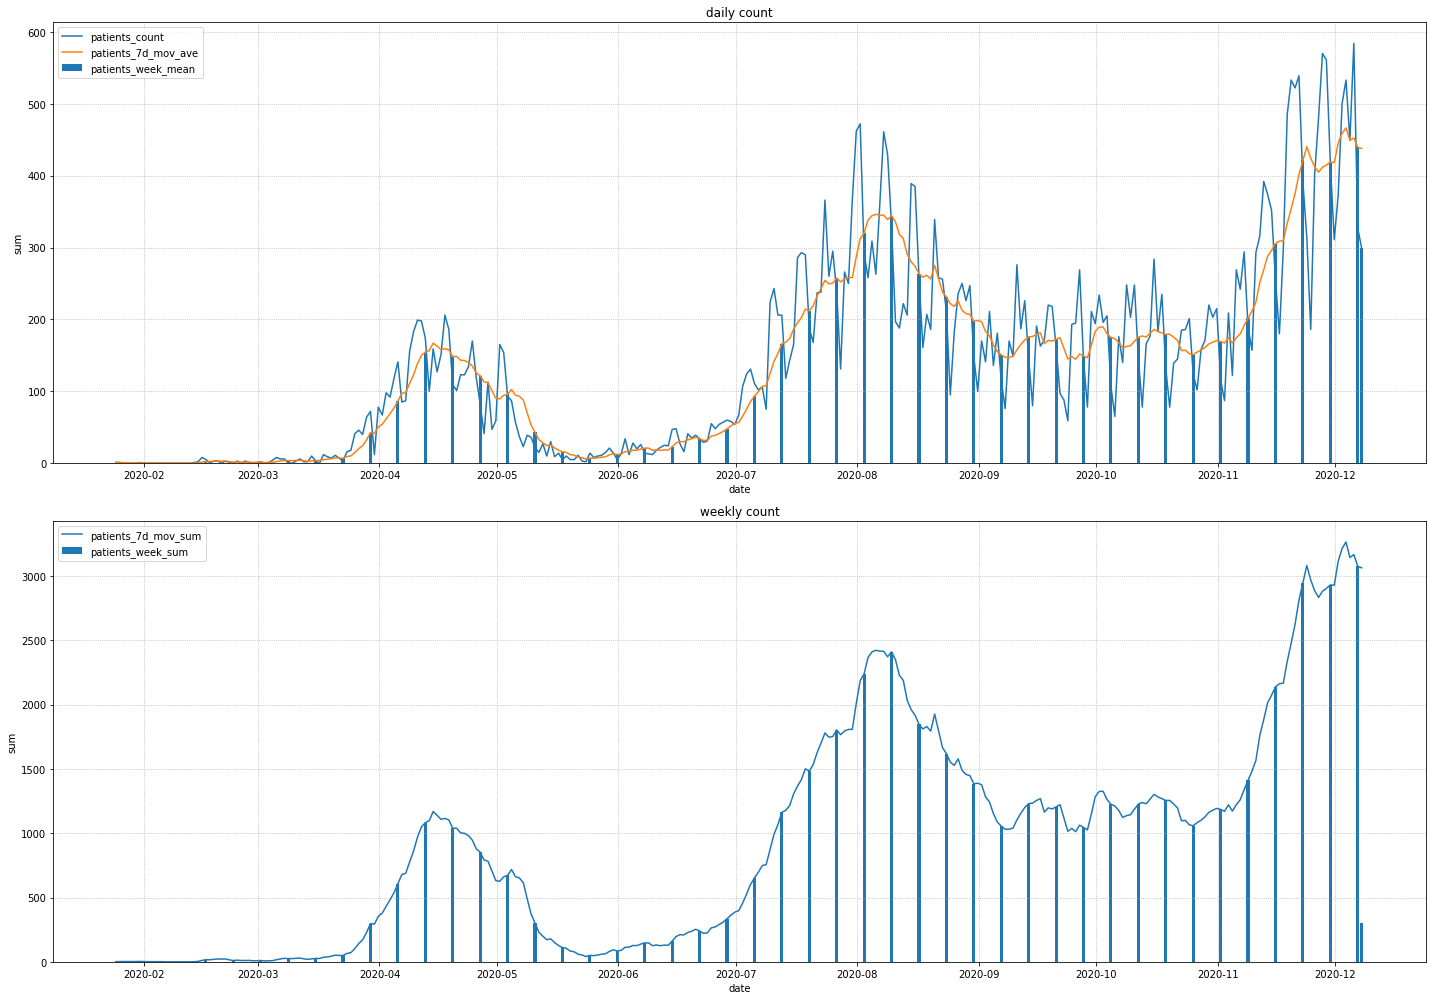

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
304,1.606118e+09,2020,11,23,0,1,0,0,0,0,0,304,0,230,663,588.714286,4121.0,0,0.0,0.0,314,440.285714,3082.0
305,1.606205e+09,2020,11,24,0,0,0,0,0,1,0,305,0,231,556,612.285714,4286.0,0,0.0,0.0,186,424.285714,2970.0
306,1.606291e+09,2020,11,25,0,0,0,0,0,0,1,306,0,232,472,601.714286,4212.0,0,0.0,0.0,401,412.285714,2886.0
307,1.606378e+09,2020,11,26,0,0,0,0,1,0,0,307,0,233,484,590.714286,4135.0,0,0.0,0.0,481,404.857143,2834.0
308,1.606464e+09,2020,11,27,1,0,0,0,0,0,0,308,0,234,517,577.714286,4044.0,0,0.0,0.0,570,411.714286,2882.0
309,1.606550e+09,2020,11,28,0,0,1,0,0,0,0,309,0,235,590,557.714286,3904.0,0,0.0,0.0,561,414.857143,2904.0
310,1.606637e+09,2020,11,29,0,0,0,1,0,0,0,310,0,236,496,539.714286,3778.0,0,0.0,0.0,418,418.714286,2931.0
311,1.606723e+09,2020,11,30,0,1,0,0,0,0,0,311,0,237,510,517.857143,3625.0,0,0.0,0.0,311,418.285714,2928.0
312,1.606810e+09,2020,12,1,0,0,0,0,0,1,0,312,0,238,456,503.571429,3525.0,0,0.0,0.0,372,444.857143,3114.0
313,1.606896e+09,2020,12,2,0,0,0,0,0,0,1,313,0,239,423,496.571429,3476.0,0,0.0,0.0,500,459.000000,3213.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            319 non-null    float64
 1   year                 319 non-null    int64  
 2   month                319 non-null    int64  
 3   day                  319 non-null    int64  
 4   Fri                  319 non-null    uint8  
 5   Mon                  319 non-null    uint8  
 6   Sat                  319 non-null    uint8  
 7   Sun                  319 non-null    uint8  
 8   Thu                  319 non-null    uint8  
 9   Tue                  319 non-null    uint8  
 10  Wed                  319 non-null    uint8  
 11  passed               319 non-null    int64  
 12  emergency            319 non-null    int64  
 13  em_passed            319 non-null    int64  
 14  contacts_count       319 non-null    int64  
 15  contacts_7d_mov_ave  319 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.190000e+02,319.0,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,1.593590e+09,2020.0,6.498433,15.746082,0.144201,0.144201,0.144201,0.144201,0.141066,0.141066,0.141066,159.000000,0.153605,93.699060,750.808777,747.767055,5234.357367,1152.749216,1152.749216,8069.244514,137.940439,134.061487,938.379310
std,7.968810e+06,0.0,3.039442,8.971379,0.351845,0.351845,0.351845,0.351845,0.348636,0.348636,0.348636,92.231593,0.361136,80.708442,477.796973,465.217535,3256.542030,841.270206,688.663102,4820.641712,134.609660,121.469169,850.340522
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586722e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.500000,0.000000,5.500000,445.000000,453.928571,3177.500000,359.500000,871.214286,6098.500000,14.000000,17.071429,119.500000
50%,1.593590e+09,2020.0,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,0.000000,85.000000,597.000000,612.285714,4286.000000,1200.000000,1184.571429,8292.000000,113.000000,144.571429,1012.000000
75%,1.600459e+09,2020.0,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.500000,0.000000,164.500000,880.500000,910.500000,6373.500000,1723.500000,1644.357143,11510.500000,208.000000,189.357143,1325.500000
max,1.607328e+09,2020.0,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,318.000000,1.000000,244.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,584.000000,466.428571,3265.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,NaN,0.995291,-0.006753,-0.006686,0.006686,-0.002229,0.002229,0.004401,-0.004401,-1.317701e-18,1.000000e+00,-0.282194,0.984906,-0.104756,-0.066414,-0.066407,-0.000968,0.053435,0.053435,0.728201,0.787725,0.787776
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.952915e-01,NaN,1.000000,-0.103518,-0.008610,0.006093,-0.002729,0.003153,0.004661,-0.004242,1.693118e-03,9.952915e-01,-0.279107,0.979422,-0.101439,-0.064091,-0.064084,0.000130,0.056383,0.056383,0.726588,0.785662,0.785719
day,-6.753383e-03,NaN,-0.103518,1.000000,0.020602,0.005659,0.004663,-0.009285,-0.002588,-0.001582,-1.766865e-02,-6.753383e-03,-0.002483,-0.004023,-0.005307,0.004664,0.004658,0.008658,-0.009235,-0.009235,-0.024706,-0.023806,-0.023868
Fri,-6.686378e-03,NaN,-0.008610,0.020602,1.000000,-0.168498,-0.168498,-0.168498,-0.166352,-0.166352,-1.663522e-01,-6.686378e-03,-0.001629,-0.004447,-0.017026,-0.006112,-0.006110,0.045508,-0.006412,-0.006412,0.088954,-0.003877,-0.003915
Mon,6.686378e-03,NaN,0.006093,0.005659,-0.168498,1.000000,-0.168498,-0.168498,-0.166352,-0.166352,-1.663522e-01,6.686378e-03,-0.001629,0.007181,0.039634,-0.003494,-0.003492,0.225159,-0.006412,-0.006412,-0.157643,0.008795,0.008803
Sat,-2.228793e-03,NaN,-0.002729,0.004663,-0.168498,-0.168498,1.000000,-0.168498,-0.166352,-0.166352,-1.663522e-01,-2.228793e-03,-0.001629,-0.000571,0.038212,-0.004627,-0.004626,-0.268621,-0.006412,-0.006412,0.118102,0.002252,0.002224
Sun,2.228793e-03,NaN,0.003153,-0.009285,-0.168498,-0.168498,-0.168498,1.000000,-0.166352,-0.166352,-1.663522e-01,2.228793e-03,-0.001629,0.003305,-0.013379,-0.003494,-0.003492,-0.247809,-0.006412,-0.006412,-0.046495,0.005664,0.005661
Thu,4.400814e-03,NaN,0.004661,-0.002588,-0.166352,-0.166352,-0.166352,-0.166352,1.000000,-0.164234,-1.642336e-01,4.400814e-03,0.002192,0.002072,-0.006483,0.007205,0.007207,0.075763,0.008628,0.008628,0.096268,0.001216,0.001240
Tue,-4.400814e-03,NaN,-0.004242,-0.001582,-0.166352,-0.166352,-0.166352,-0.166352,-0.164234,1.000000,-1.642336e-01,-4.400814e-03,0.002192,-0.005751,-0.025455,0.004751,0.004753,0.100562,0.008628,0.008628,-0.059524,-0.009734,-0.009717


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,1.606982e+09,0,0,0,0,1,0,0,314,0,240,463,0,533,466.428571,3265.0
315,1.607069e+09,1,0,0,0,0,0,0,315,0,241,406,0,449,449.142857,3144.0
316,1.607155e+09,0,0,1,0,0,0,0,316,0,242,541,0,584,452.428571,3167.0
317,1.607242e+09,0,0,0,1,0,0,0,317,0,243,413,0,327,439.428571,3076.0


In [26]:
import seaborn as sns

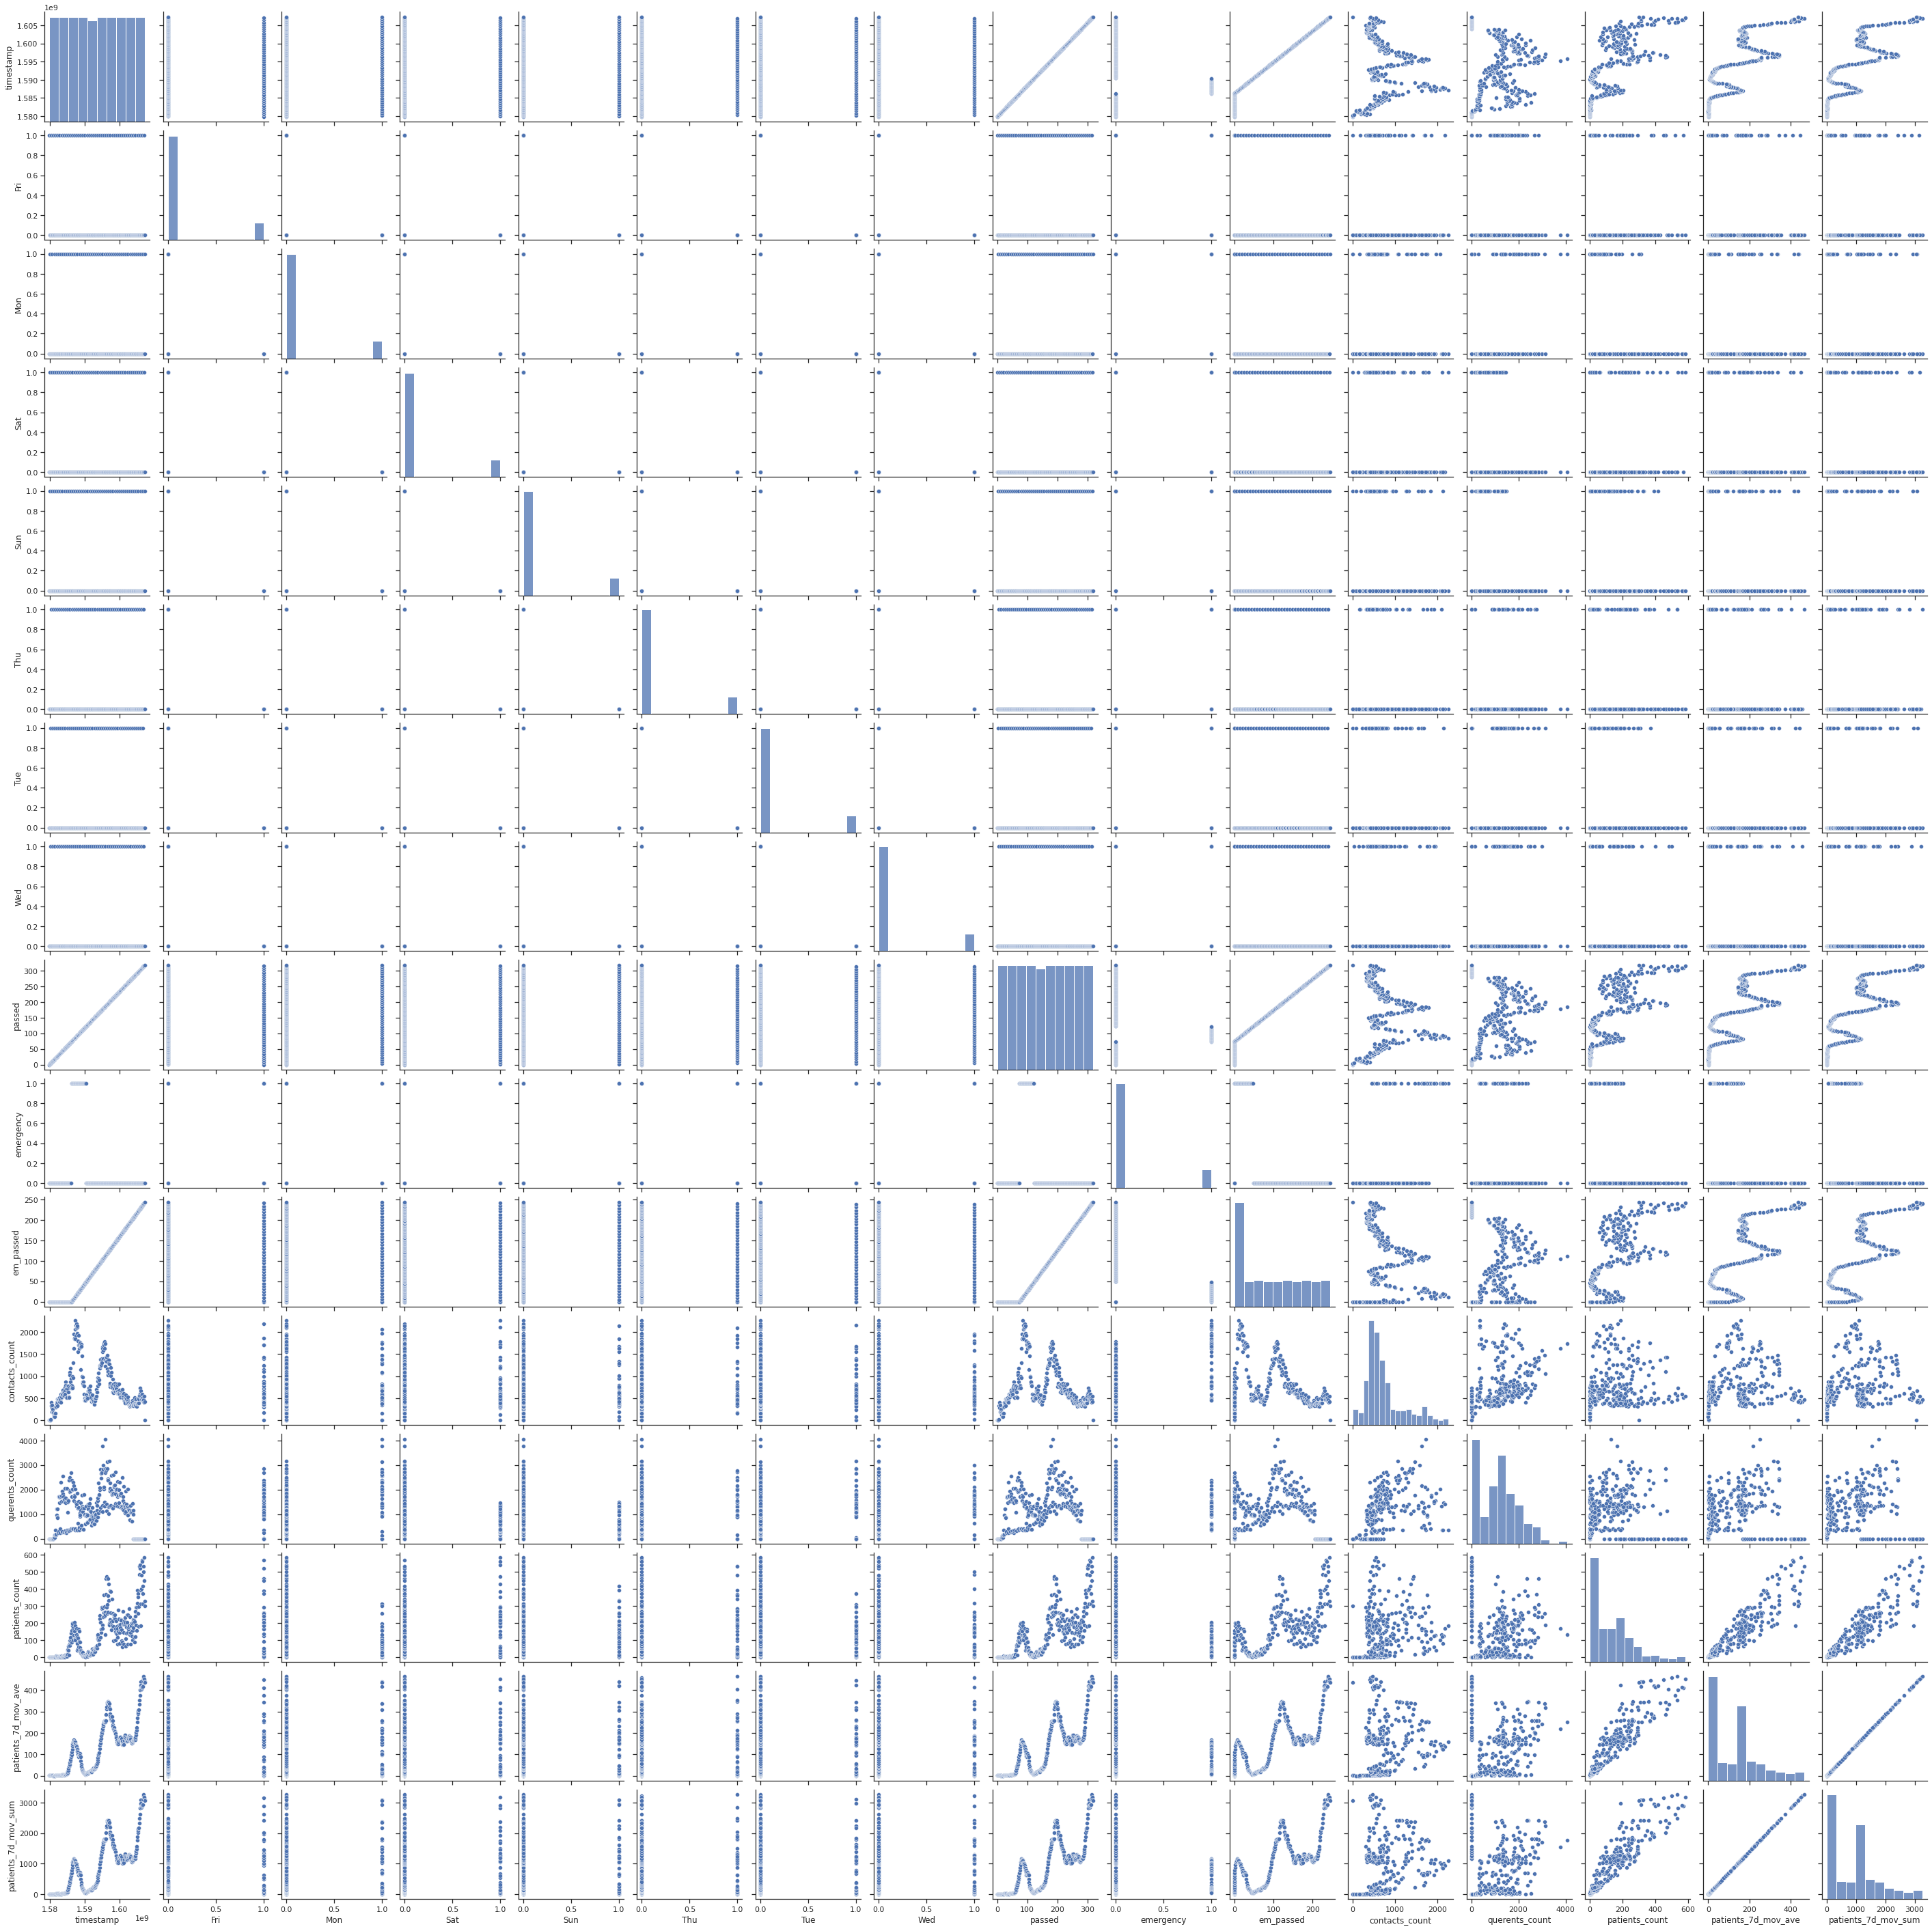

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
